# Posthoc Analysis of IMAGEN:
The preliminary results in our IMAGEN paper advocates for a more in-depth understanding of what contributes to the significant performance of the ML models for the three time-points: <br>
<li>Baseline (<b>BL</b>): Age <tr> <b>14</b></li>
<li>Follow 2 year (<b>FU2</b>): Age <b>19</b></li>
<li>Follow 3 year (<b>FU3</b>): Age <b>22</b></li>

<br>
Such in-depth understanding can be achieved by performing follow-up analysis:

In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from imagen_posthocloader import *
from plot_results_posthoc import *
import h5py as h5
%matplotlib inline

In [2]:
DATA_DIR = "/ritter/share/data/IMAGEN"
posthoc = IMAGEN_posthoc()

## (roshan) Find the most informative features

In [3]:
### helper funcs
def get_featuretype_cnt(fs):
    dfc = pd.DataFrame()
    dfc.loc[0, 'Total'] = len(fs)
    dfc.loc[0, 'DTI'] = len([f for f in fs if 'DTI'==f.split('_')[0]])
    dfc.loc[0, 'T1w'] = len([f for f in fs if 'T1w'==f.split('_')[0]])
    dfc.loc[0, 'subcor'] = len([f for f in fs if 'subcor'==f.split('_')[1]])
    dfc.loc[0, 'subcor_area'] = len([f for f in fs if 'subcor'==f.split('_')[1] and 'mean'==f.split('_')[-1]])
    dfc.loc[0, 'subcor_vol'] = len([f for f in fs if 'subcor'==f.split('_')[1] and 'volume'==f.split('_')[-1]])
    
    dfc.loc[0, 'cor'] = len([f for f in fs if 'cor'==f.split('_')[1]])
    dfc.loc[0, 'cor_area'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'area'==f.split('-')[-1]])
    dfc.loc[0, 'cor_curv'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'curv' in f.split('-')[-1]])
    dfc.loc[0, 'cor_vol'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'vol' in f.split('-')[-1]])
    dfc.loc[0, 'cor_thick'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'thickness' in f.split('-')[-1]])
    dfc.loc[0, 'cor_foldind'] = len([f for f in fs if 'cor'==f.split('_')[1] and 'foldind' == f.split('-')[-1]])
    
    dfc = dfc.astype(int)
    
    return dfc.style.background_gradient(cmap='gray', vmin=0, vmax=len(top_features))

#### playground

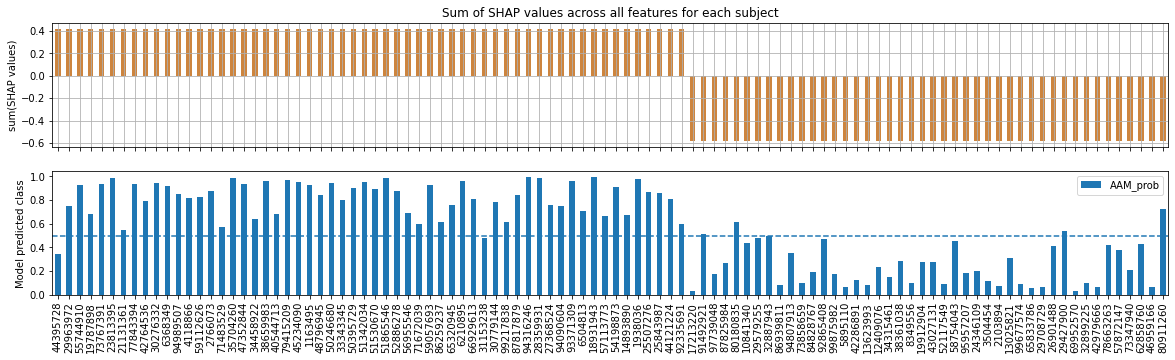

In [14]:
# 1) how does SHAP work? Do the SHAP values consistently sum to 1 or 0 or -1 across all features?
FU3 = "newholdout-clean-fu3-espad-fu3-19a-binge-n102.h5"
X_FU3, X_col_FU3, Other = posthoc.get_holdout_data(FU3)
# load raw SHAP values from run 0
RBF0_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf0_FU3.sav"
with open(RBF0_FU3, 'rb') as fp:
    load_shap_values = pickle.load(fp)
df = pd.DataFrame(load_shap_values.values, columns=X_col_FU3, index=Other[1])
df = df.sum(axis=1).sort_values(ascending=False)

f, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 5))
# sum over all features
ax = df.plot.bar(rot=90, ax=axes[0], grid=True, color='peru',
    xlabel='Subject IDs (holdout)', ylabel=r'sum(SHAP values)',                                                 
    title='Sum of SHAP values across all features for each subject',
    legend=False)

# get the model predictions
df_result = pd.read_csv("/ritter/share/jihoon/imagen_ml/MLpipelines/results/holdout_all-tp-clean_run.csv")
df_result = df_result.loc[(df_result[['tp','technique','model','trial']]==('fu3', 'cb', 'SVM-rbf', 0)).all(axis=1)]

scores = pd.DataFrame()

scores['ID'] = eval(df_result['holdout_ids'].values[0])
scores['AAM_prob'] = (np.array(eval(df_result['holdout_probs'].values[0]))[:,1])#>=0.51).astype(int)
scores = scores.set_index('ID').reindex(df.index)
scores.plot(kind='bar', rot=90, ax=axes[1], ylabel='Model predicted class')
axes[1].axhline(0.5, ls='dashed')
plt.show()

Lesson learned: The `SHAP values` sum to either `0.42` or `-0.58` for all subjects. The base-value is `0.58`. Therefore, when added to the base-value it becomes either `1` or `0`. I believe the subjects for whom the SHAP values sum to `0.42` (or `1`) are the subjects that the model predicts as class 1 or AAM. And the subjects for whom the SHAP values sum to `0.58` (or `0`), are predicted by the model as class 0.

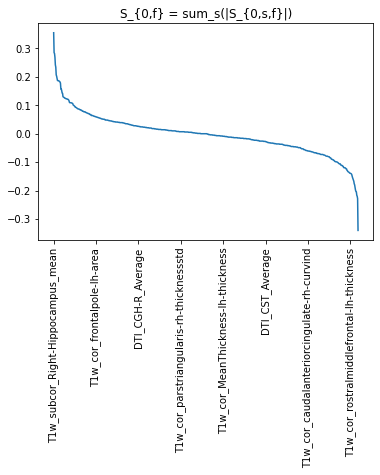

In [5]:
# sum over all subjects per features
# df = pd.DataFrame(load_shap_values.values, columns=X_col_FU3, index=Other[1])
df_sf = df.sum(axis=0).sort_values(ascending=False)
df_sf.plot(title='S_{0,f} = sum_s(|S_{0,s,f}|)', rot=90)
plt.show()

In [6]:
# Features with top sum, ignoring the sign of SHAP values ?!
top_features = df_sf[df_sf.abs()>.2].index.to_list()
print(top_features)
get_featuretype_cnt(top_features)

['T1w_subcor_Right-Hippocampus_mean', 'T1w_cor_rostralanteriorcingulate-rh-thickness', 'T1w_subcor_Right-Amygdala_volume', 'T1w_cor_superiorfrontal-rh-thickness', 'T1w_subcor_Right-Caudate_mean', 'T1w_cor_inferiorparietal-rh-thicknessstd', 'T1w_cor_rostralanteriorcingulate-rh-volume', 'T1w_subcor_Optic-Chiasm_volume', 'DTI_PLIC-R_Average', 'T1w_cor_parahippocampal-rh-area', 'T1w_cor_parstriangularis-rh-area', 'T1w_cor_parahippocampal-lh-thicknessstd', 'T1w_cor_cuneus-rh-thickness', 'T1w_subcor_Left-Pallidum_mean']


,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,14,1,13,5,3,2,8,2,0,1,5,0


1. Are the values normally distributed? **No. Skewed right distribution.** 
2. how do the cumulative sum look? Are there some big players holding most of the SHAP values? **No big players but some do have a higher value**

#### Show mean|SHAP| of all features

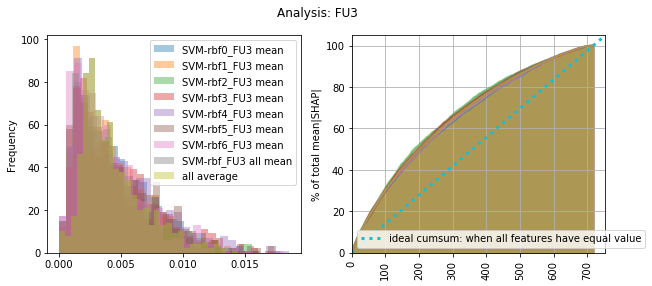

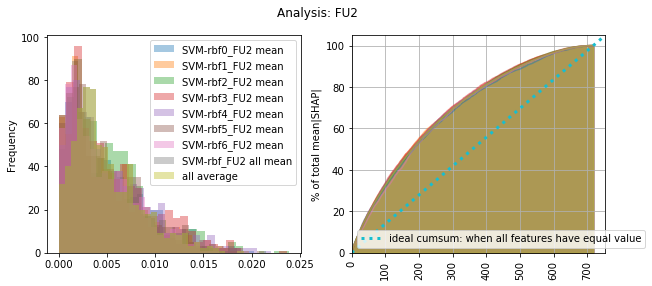

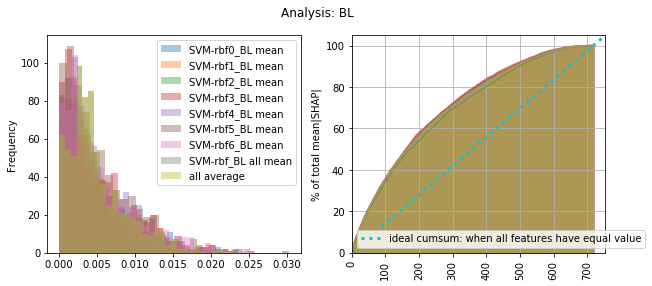

In [4]:
for tp in ['FU3', 'FU2', 'BL']:
    df = posthoc.read_SHAP(f'all_{tp}_SHAP.csv').filter(regex="SVM-rbf.* mean")
    df["all average"] =  df.apply(np.mean, axis=1)
    df = df.sort_values("all average", ascending=False, ignore_index=True)
    
    f, axes = plt.subplots(1,2, figsize=(10,4))
    plt.suptitle(f'Analysis: {tp}')
    # are the values normally distributed?
    for c in df:
        df[c].plot.hist(bins=30, alpha=0.4, legend=True, ax=axes[0])

    # how do the cumulative sum look? Are there some big players holding most of the SHAP values?
    # to determine the threshold
    # calculate the percentage for the y-axis
    cumsum = df.cumsum().apply(lambda x: 100*x/x.max())
    ax = cumsum.plot.area(stacked=False, rot=90, legend=False, ax=axes[1], grid=True, ylabel='% of total mean|SHAP|')
    ax.set_xlim([0, ax.get_xlim()[-1]])
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='dotted', lw=3, label='ideal cumsum: when all features have equal value')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], [labels[0]])
    plt.show()

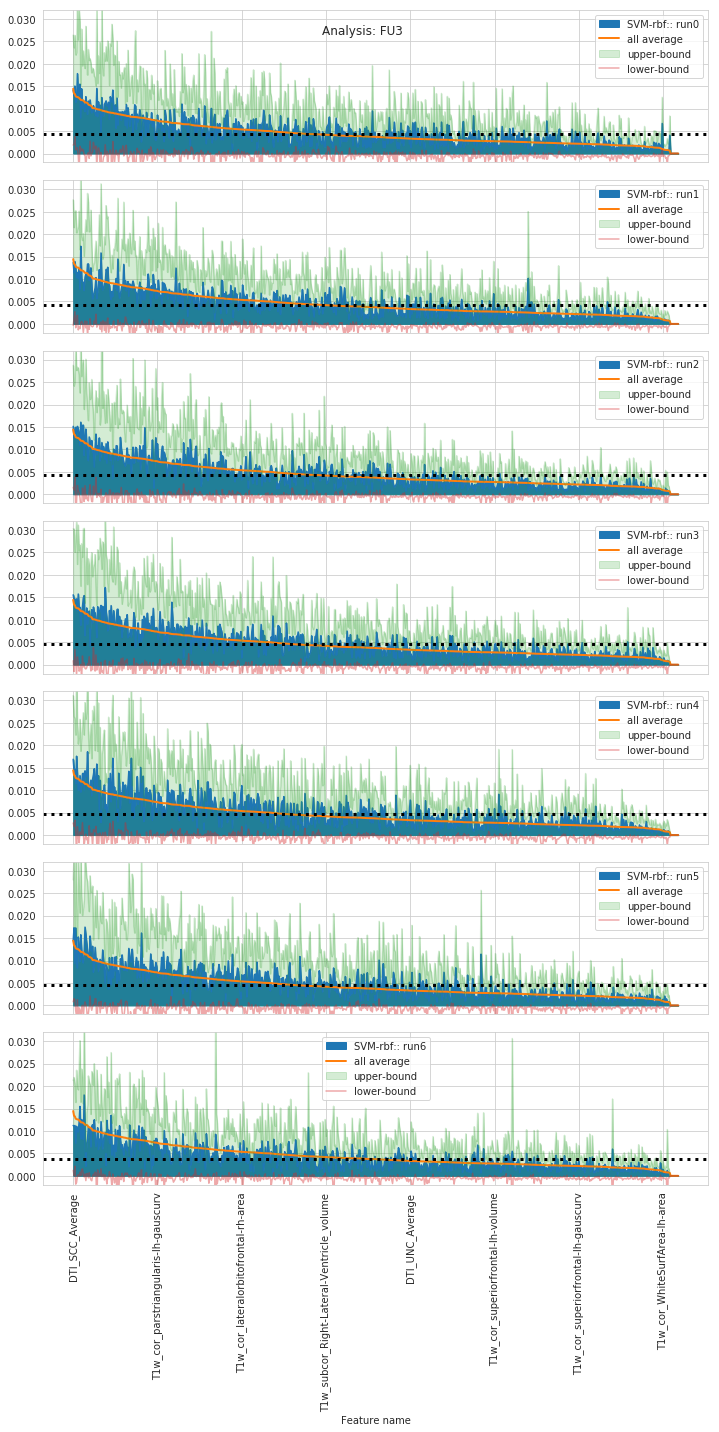

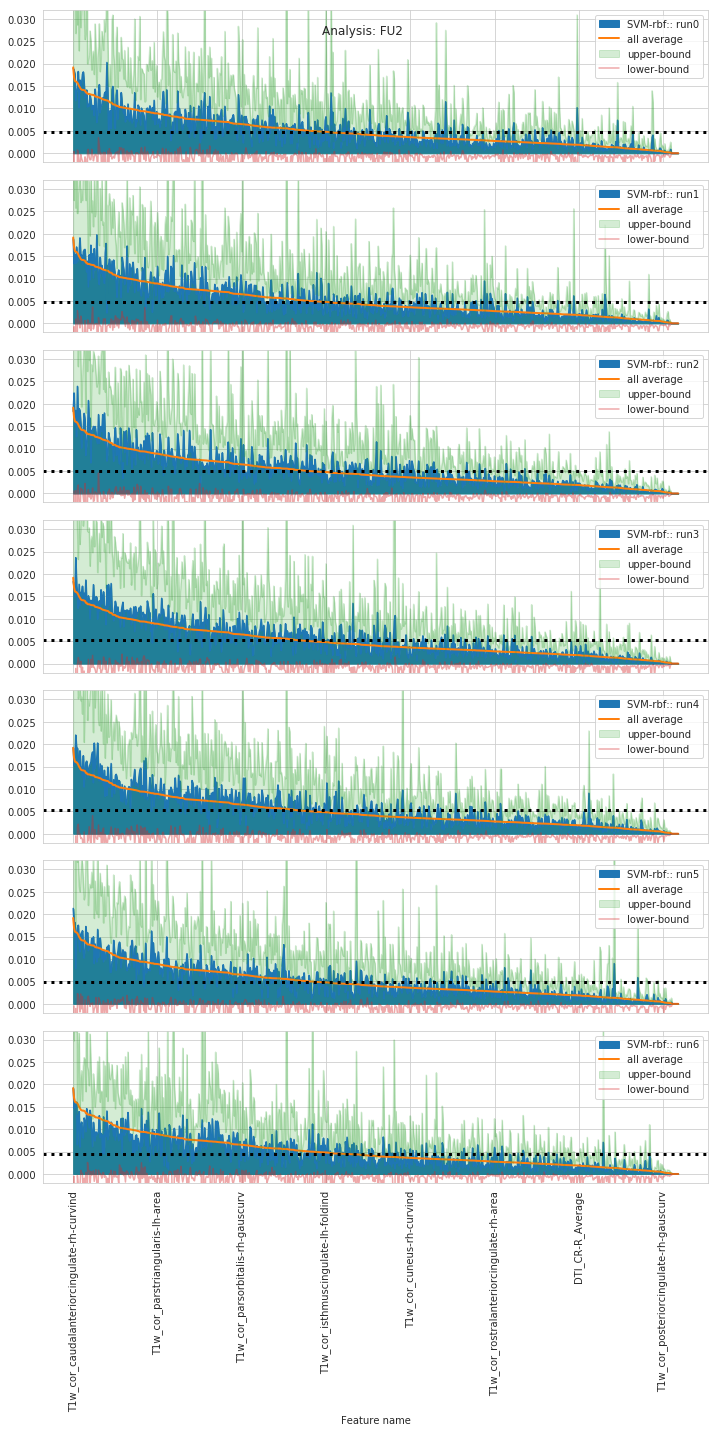

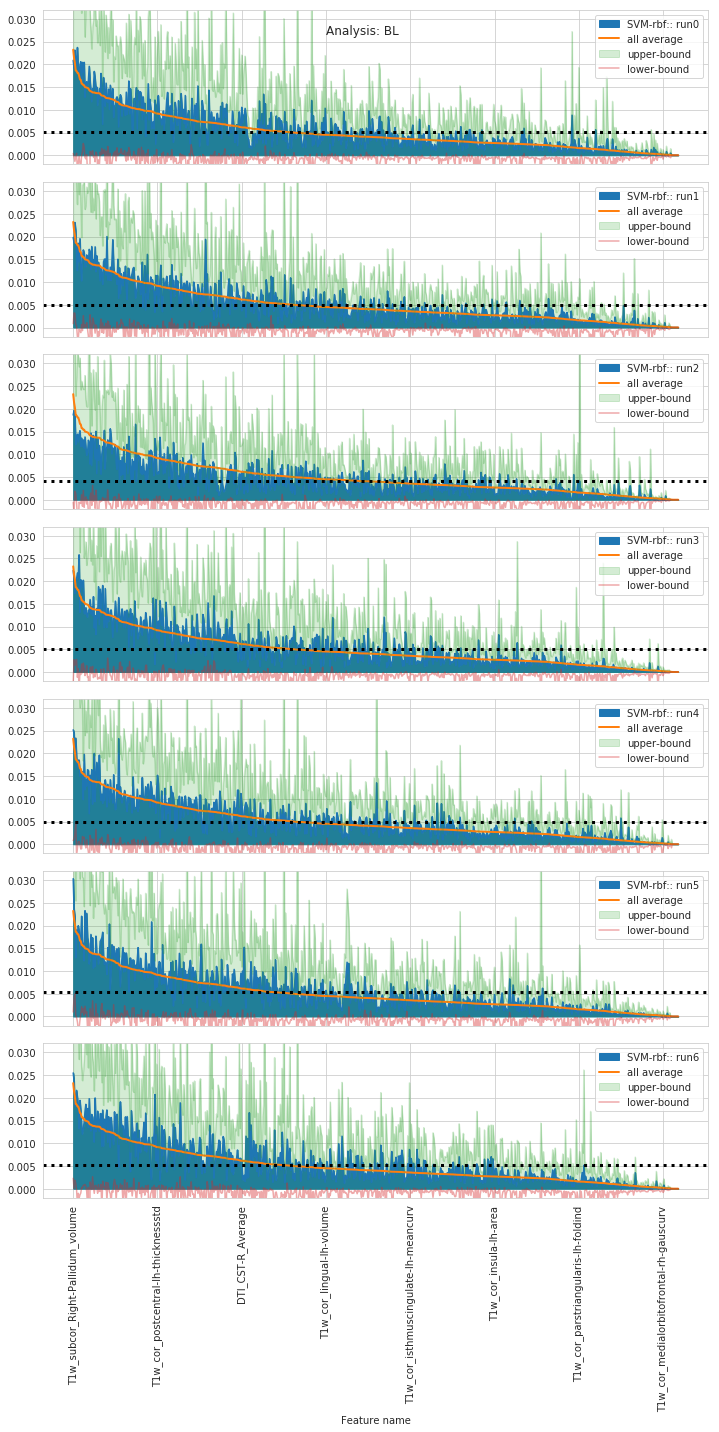

In [7]:
for tp in ['FU3', 'FU2', 'BL']:
    f, axes = plt.subplots(7,1, figsize=(10,20), sharex=True, sharey=True)
    sns.set_style('whitegrid')
    plt.suptitle(f'Analysis: {tp}')

    for i, axis in enumerate(axes.ravel()):
        df = posthoc.read_SHAP(f'all_{tp}_SHAP.csv').set_index('Feature name').filter(regex="SVM-rbf.*")
        df["all average"] =  df.filter(regex="SVM-rbf.* mean").apply(np.mean, axis=1)
        df = df.sort_values("all average", ascending=False)
        df.plot(y=f'SVM-rbf{i}_{tp} mean', label=f'SVM-rbf:: run{i}',  kind='area', 
                       rot=90, ax=axis, legend=True)
        df["all average"].plot(lw=2, label="all average", rot=90, ax=axis, legend=True)  

        axis.set_ylim([-0.002,0.032])

        # plot the upper and lower standard deviations in SHAP
        df[f'SVM-rbf{i}_{tp} std_up'] = df[f'SVM-rbf{i}_{tp} mean']  + df[f'SVM-rbf{i}_{tp} std'] 
        df[f'SVM-rbf{i}_{tp} std_down'] = df[f'SVM-rbf{i}_{tp} mean']  - df[f'SVM-rbf{i}_{tp} std']

        df.plot(y=f'SVM-rbf{i}_{tp} std_up', kind='area', label='upper-bound', rot=90, ax=axis, legend=True,  alpha=0.2, stacked=False)
        df.plot(y=f'SVM-rbf{i}_{tp} std_down', kind='line', label='lower-bound', rot=90, ax=axis, legend=True, alpha=0.4, stacked=False)

        axis.axhline(df[f'SVM-rbf{i}_{tp} mean'].mean(), ls='dotted',lw=3, color='k')
    #     df_sorted[f'SVM-rbf{i}_{tp} mean'].cumsum().plot.area(alpha=0.2, rot=90, ax=axis)
    # SHAP_SVMrbf.filter(regex='SVM-rbf.* std').sort_values(
    #     by='SVM-rbf_{tp} all std', ascending=False).drop(columns=['SVM-rbf_{tp} all std']).plot(
    # alpha=0.5, rot=90, ax=axes[1])
    # SHAP_SVMrbf['SVM-rbf_{tp} all std'].sort_values(ascending=False).plot(lw=2, rot=90, ax=axes[1])
    plt.tight_layout()
    plt.show()

#### Show informative features: FU3, FU2, BL

In [6]:
top_features_all = {}
for tp in ['FU3', 'FU2', 'BL']:
    print(f'------------------------------------\n    Analysis: {tp}   \n------------------------------------')

    df = posthoc.read_SHAP(f'all_{tp}_SHAP.csv').set_index('Feature name').filter(regex="SVM-rbf.* mean")
    df["all average"] =  df.filter(regex="SVM-rbf.* mean").apply(np.mean, axis=1)
    df = df.sort_values("all average", ascending=False)   
    # set the threshold as 2 times the average mean|SHAP| 
    thresh = 1.9 * df['all average'].mean()

#     display(df.head(20).style.background_gradient(vmin=thresh, cmap='PuBu_r').highlight_between(right=thresh, color='black'))
    
    # top features are those which beat the threshold ####in at least 6 out of the 7
    top_features = df[df.filter(regex="SVM-rbf.* mean").apply(lambda x: x>=thresh).all(axis=1)]#.sum(axis=1) >= len(df.filter(regex="SVM-rbf.* mean").columns)-1]
    top_features = top_features.index.to_list()
    display(top_features)
    display(get_featuretype_cnt(top_features))
    top_features_all.update({tp:top_features})

------------------------------------
    Analysis: FU3   
------------------------------------


['DTI_SCC_Average',
 'T1w_cor_lateraloccipital-rh-thickness',
 'T1w_subcor_CSF_mean',
 'T1w_subcor_Brain-Stem_mean',
 'T1w_subcor_Right-Amygdala_volume',
 'T1w_cor_parahippocampal-rh-area',
 'T1w_cor_cuneus-rh-thickness',
 'T1w_subcor_Left-Hippocampus_mean',
 'T1w_subcor_Left-choroid-plexus_volume',
 'DTI_RLIC-R_Average',
 'DTI_RLIC_Average']

,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,11,3,8,5,3,2,3,1,0,0,2,0


------------------------------------
    Analysis: FU2   
------------------------------------


['T1w_cor_caudalanteriorcingulate-rh-curvind',
 'T1w_cor_caudalanteriorcingulate-lh-thicknessstd',
 'T1w_cor_cuneus-lh-curvind',
 'T1w_cor_pericalcarine-lh-curvind',
 'T1w_subcor_CC_Anterior_mean',
 'T1w_cor_cuneus-rh-thickness',
 'DTI_CST-L_Average',
 'T1w_subcor_WM-hypointensities_mean',
 'T1w_cor_frontalpole-lh-curvind',
 'T1w_subcor_Left-Cerebellum-Cortex_mean',
 'T1w_cor_precentral-rh-gauscurv',
 'T1w_cor_rostralanteriorcingulate-lh-thickness',
 'T1w_subcor_Brain-Stem_mean',
 'T1w_cor_fusiform-lh-thicknessstd',
 'T1w_cor_inferiortemporal-lh-thicknessstd',
 'T1w_subcor_Right-Accumbens-area_mean',
 'DTI_RLIC-R_Average',
 'T1w_subcor_Left-Inf-Lat-Vent_volume']

,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,18,2,16,6,5,1,10,0,5,0,5,0


------------------------------------
    Analysis: BL   
------------------------------------


['T1w_subcor_Right-Pallidum_volume',
 'T1w_cor_temporalpole-lh-volume',
 'T1w_subcor_Right-Cerebellum-Cortex_volume',
 'T1w_subcor_CC_Anterior_mean',
 'T1w_cor_rostralmiddlefrontal-lh-thicknessstd',
 'T1w_cor_parahippocampal-rh-area',
 'T1w_cor_inferiorparietal-rh-volume',
 'T1w_cor_lateraloccipital-lh-thickness',
 'T1w_cor_bankssts-rh-meancurv',
 'T1w_cor_parahippocampal-rh-volume',
 'T1w_cor_pericalcarine-lh-thickness',
 'DTI_PCR_Average',
 'T1w_cor_superiorparietal-rh-thicknessstd',
 'DTI_PCR-R_Average',
 'T1w_cor_paracentral-lh-area',
 'T1w_cor_parsorbitalis-lh-area',
 'T1w_cor_superiorparietal-lh-thicknessstd',
 'T1w_cor_cuneus-rh-volume',
 'T1w_cor_pericalcarine-rh-thickness',
 'T1w_cor_cuneus-rh-thickness',
 'T1w_subcor_CC_Anterior_volume',
 'T1w_cor_medialorbitofrontal-lh-thicknessstd',
 'DTI_ALIC-R_Average',
 'T1w_cor_isthmuscingulate-rh-thicknessstd',
 'T1w_cor_postcentral-rh-thickness',
 'T1w_subcor_Brain-Stem_mean',
 'DTI_SCC_Average',
 'T1w_cor_medialorbitofrontal-lh-area'

,Total,DTI,T1w,subcor,subcor_area,subcor_vol,cor,cor_area,cor_curv,cor_vol,cor_thick,cor_foldind
0,32,4,28,6,2,4,22,4,3,5,10,0


#### Plot the beeswarm for the selected features

In [ ]:
H5 = {'BL': "newholdout-clean-bl-espad-fu3-19a-binge-n102.h5",
    'FU2': "newholdout-clean-fu2-espad-fu3-19a-binge-n102.h5",
    'FU3': "newholdout-clean-fu3-espad-fu3-19a-binge-n102.h5"}

In [ ]:
SHAP = RBF0_FU3

for tp in top_features_all:
    feature_names = top_features_all[tp]
    
    # get the feature values from the hdf5 input hdf5 file
    with h5.File('/ritter/share/data/IMAGEN/h5files/'+H5['BL'], "r") as f:
        feature_vals = f['X']
        all_feature_names = [name[:-1] if (')'==name[-1]) else name for name in f.attrs['X_col_names']]
        
        feature_idx = np.where(np.isin(all_feature_names, feature_names))[0]
        feature_vals = feature_vals[:, feature_idx]
        # repeat it 7 times just to be compatible with 7 runs of shap values in summary_plot()
        feature_vals = np.tile(feature_vals,(7,1))
#     display(feature_vals.shape)

    # get SHAP values
    shap_values = None
    for i in range(7): 
        # concatenate results from 7 runs as separate subjects
        with open(f"/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf{i}_{tp}.sav", 'rb') as fp:
            vals = pickle.load(fp).values[:,feature_idx]
            if shap_values is None:
                shap_values = vals
            else:
                shap_values = np.vstack((shap_values, vals))

#     display(shap_values.shape)
    shap.summary_plot(shap_values, features=feature_vals, feature_names=feature_names, 
                      max_display=len(feature_names))

# 4. Visualization SHAP
## 4.1. SHAP values

### 4.1.1. Get the plot

<b> Load the dataset </b>

In [ ]:
BL = "newholdout-clean-bl-espad-fu3-19a-binge-n102.h5"
FU2 = "newholdout-clean-fu2-espad-fu3-19a-binge-n102.h5"
FU3 = "newholdout-clean-fu3-espad-fu3-19a-binge-n102.h5"

RBF0_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf0_FU3.sav"
RBF1_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf1_FU3.sav"
RBF2_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf2_FU3.sav"
RBF3_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf3_FU3.sav"
RBF4_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf4_FU3.sav"
RBF5_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf5_FU3.sav"
RBF6_FU3 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf6_FU3.sav"

RBF0_FU2 = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf0_FU2.sav"
RBF0_BL = "/ritter/share/data/IMAGEN/posthoc/explainers/SVM-rbf0_BL.sav"

<b> ROI 01: summary bar plot of feature importnace </b>

In [ ]:
# Plot type: 'Bar', 'Swarm', 'Sex', and 'Class'
SHAP_plot(FU3, RBF0_FU2, 'Bar')#, fig=True)

In [ ]:
# Plot type: 'Bar', 'Swarm', 'Sex', and 'Class'
SHAP_plot(FU3, RBF0_FU3, 'Bar')#, fig=True)

<b> ROI 02: swarm plot showing shap values vs feature values ordered by feature importance </b>

In [ ]:
SHAP_plot(FU3, RBF0_FU2, 'Swarm')#, fig=True)

In [ ]:
SHAP_plot(FU3, RBF0_FU3, 'Swarm')#, fig=True)

<b> ROI 03: Class difference plot showing shap values vs feature values ordered by feature importance </b>

In [ ]:
SHAP_plot(FU3, RBF0_BL, 'Class')#, fig=True)

In [ ]:
SHAP_plot(FU3, RBF0_FU2, 'Class')#, fig=True)

In [ ]:
SHAP_plot(FU3, RBF0_FU3, 'Class')#, fig=True)

<b> ROI 04: Sex difference plot showing shap values vs feature values ordered by feature importance </b>

In [ ]:
# SHAP_plot(FU3, RBF0_FU3, 'Sex')#, fig=True)

### 4.1.2. Distribution sorted by descending order of mean|SHAP value| in SVM-rbf

<b>Load the SHAP</b>

In [ ]:
DF = posthoc.read_SHAP('all_mofm_abs_SHAP.csv')

In [ ]:
DF = posthoc.to_sorted_mean_SHAP(DF, 'SVM-rbf', 'FU3')
DF = posthoc.to_sorted_mean_SHAP(DF, 'SVM-rbf', 'FU2')
DF = posthoc.to_sorted_mean_SHAP(DF, 'SVM-rbf', 'BL', save=True)

In [ ]:
sorted_SHAP = posthoc.read_SHAP('all_sorted_mean_SHAP.csv')
sorted_SHAP

In [ ]:
SHAP_SVM_rbf = posthoc.read_SHAP('IMAGEN_SHAP_SVM_rbf.csv')
SHAP_SVM_rbf

In [ ]:
sorted_SHAP.columns[60:67]

In [ ]:
sorted_SHAP.columns[67:74]

<b>mean|SHAP| distribution in FU3</b>

In [ ]:
m_FU3_sorted_SHAP = sorted_SHAP[['sorted SVM-rbf0_FU3 mean', 'sorted SVM-rbf1_FU3 mean',
                                 'sorted SVM-rbf2_FU3 mean', 'sorted SVM-rbf3_FU3 mean',
                                 'sorted SVM-rbf4_FU3 mean', 'sorted SVM-rbf5_FU3 mean',
                                 'sorted SVM-rbf6_FU3 mean']]
m_FU2_sorted_SHAP = sorted_SHAP[['sorted SVM-rbf0_FU2 mean', 'sorted SVM-rbf1_FU2 mean',
                                 'sorted SVM-rbf2_FU2 mean', 'sorted SVM-rbf3_FU2 mean',
                                 'sorted SVM-rbf4_FU2 mean', 'sorted SVM-rbf5_FU2 mean',
                                 'sorted SVM-rbf6_FU2 mean']]
m_BL_sorted_SHAP = sorted_SHAP[['sorted SVM-rbf0_BL mean', 'sorted SVM-rbf1_BL mean',
                                'sorted SVM-rbf2_BL mean', 'sorted SVM-rbf3_BL mean',
                                'sorted SVM-rbf4_BL mean', 'sorted SVM-rbf5_BL mean',
                                'sorted SVM-rbf6_BL mean']]

In [ ]:
mean = round(sorted_SHAP.loc[143][60:67].mean(), 5)
std = round(sorted_SHAP.loc[143][67:74].std(), 5)
# mean
sorted_SHAP[sorted_SHAP.columns[60:67]].plot()

# text
plt.title("SVM rbf's mean|SHAP| and std")
plt.axvline(x=143, ymin=0.1, ymax=0.9)
plt.text(100, 0.0002, '(n=143)')
plt.text(150, 0.008, f"{mean} \u00B1{std}")
# std
sorted_SHAP[sorted_SHAP.columns[67:74]].plot()

In [ ]:
number = math.floor(len(SHAP_SVM_rbf)*0.2)
ST_SVM_rbf = SHAP_SVM_rbf.loc[:number]
# Mean
ST_SVM_rbf[ST_SVM_rbf.columns[76:83]].plot()
# Std
ST_SVM_rbf[ST_SVM_rbf.columns[83:]].plot()
print(f"20% point: {number}")

In [ ]:
SHAP_SVM_rbf

### 4.1.3. Consistent feature in FU3 on SVM-rbf 

<b>Generate the SHAP table</b>

In [ ]:
DF = SHAP_SVM_rbf

<b> Top 1 - Common feature importance (n=8)

In [ ]:
SHAP_top30 = SHAP_SVM_rbf.loc[:7]
DF = SHAP_top30
SHAP_table(DF, viz = True)

<b> Top 2 - Common feature importance (n=10)

In [ ]:
SHAP_top30 = SHAP_SVM_rbf.loc[:9]
DF = SHAP_top30
SHAP_table(DF, viz = True)

<b> Top 5 - Common feature importance (n=26)

In [ ]:
SHAP_top30 = SHAP_SVM_rbf.loc[:25]
DF = SHAP_top30
SHAP_table(DF, viz = True)

<b> Top 10 - Common feature importance (n=42)

In [ ]:
SHAP_top30 = SHAP_SVM_rbf.loc[:41]
DF = SHAP_top30
SHAP_table(DF, viz = True)

<b> Top 15 - Common feature importance (n=58)

In [ ]:
SHAP_top100 = SHAP_SVM_rbf.loc[:57]
DF = SHAP_top100
SHAP_table(DF, viz = True)

<b> Top 44 - Common feature importance (n=143), Short tail (20%) </b>

In [ ]:
print(f"20% point: {number}")
SHAP_20 = SHAP_SVM_rbf.loc[:number-1]
SHAP_80 = SHAP_SVM_rbf.loc[number:]
SHAP_20

In [ ]:
DF = SHAP_20
SHAP_table(DF, viz = True)

<b> Bottom 438 - Common feature importance (n=576), Long tail (20%)</b>
SHAP_80

In [ ]:
DF = SHAP_80
SHAP_table(DF, viz = False)

### 4.1.4. Feature importance, mean|SHAP| distribution

<b>generate the columns</b>

In [ ]:
import seaborn as sns; sns.set_theme(color_codes=True)

In [ ]:
SHAP = posthoc.read_SHAP('all_sorted_mean_SHAP.csv')
# SHAP = posthoc.read_SHAP('all_mofm_abs_SHAP.csv')

In [ ]:
plt.rcParams["figure.figsize"] = (100,25)

<b> All model: Model by Model

In [ ]:
SHAP_T = SHAP.transpose()
SHAP_T = SHAP_T.rename(columns=SHAP_T.iloc[0])

In [ ]:
SHAP_Model = SHAP_T.iloc[5:26]
SHAP_T = SHAP_Model.astype('float')
ax = sns.heatmap(SHAP_T)
plt.title('Heatmap of Feature importance', fontsize=40)
# plt.savefig('/figrues/Heatmap_SHAP_Model.pdf')

In [ ]:
SHAP = SHAP.sort_values(by=['Type','Lobe Region','SVM-rbf_FU3_All mean'],
                         ascending=[True,True,False])
SHAP_T = SHAP.transpose()
SHAP_T = SHAP_T.rename(columns=SHAP_T.iloc[0])

In [ ]:
SHAP_Region = SHAP_T.iloc[5:12]
SHAP_R = SHAP_Region.astype('float')
ax = sns.heatmap(SHAP_R)
plt.title('Heatmap of Feature importance', fontsize=40)
# plt.savefig('/figrues/Heatmap_SHAP_Model.pdf')

<b> GB and SVM-rbf

In [ ]:
SHAP_Two = SHAP_T.loc[['GB0_FU3 mean','GB1_FU3 mean','GB2_FU3 mean',
            'GB3_FU3 mean','GB4_FU3 mean','GB5_FU3 mean','GB6_FU3 mean',
            'SVM-rbf0_FU3 mean','SVM-rbf1_FU3 mean','SVM-rbf2_FU3 mean','SVM-rbf3_FU3 mean',
            'SVM-rbf4_FU3 mean','SVM-rbf5_FU3 mean','SVM-rbf6_FU3 mean'], :]

In [ ]:
# plt.pcolor(SHAP_Two)
# plt.title('Heatmap of Feature importance', fontsize=20)
# plt.colorbar()

In [ ]:
ax = sns.heatmap(SHAP_Two)
plt.title('Heatmap of Feature importance', fontsize=40)
# plt.savefig('figures/Heatmap_SHAP_GB_SVMrbf.pdf')

<b> All model: Trial by Trial <b>

In [ ]:
SHAP_Trial = SHAP_T.loc[['LR0_FU3 mean','SVM-lin0_FU3 mean','GB0_FU3 mean','SVM-rbf0_FU3 mean',
                         'LR1_FU3 mean','SVM-lin1_FU3 mean','GB1_FU3 mean','SVM-rbf1_FU3 mean',
                         'LR2_FU3 mean','SVM-lin2_FU3 mean','GB2_FU3 mean','SVM-rbf2_FU3 mean',
                         'LR3_FU3 mean','SVM-lin3_FU3 mean','GB3_FU3 mean','SVM-rbf3_FU3 mean',
                         'LR4_FU3 mean','SVM-lin4_FU3 mean','GB4_FU3 mean','SVM-rbf4_FU3 mean',
                         'LR5_FU3 mean','SVM-lin5_FU3 mean','GB5_FU3 mean','SVM-rbf5_FU3 mean',
                         'LR6_FU3 mean','SVM-lin6_FU3 mean','GB6_FU3 mean','SVM-rbf6_FU3 mean'], :]

In [ ]:
# plt.pcolor(SHAP_Trial)
# plt.title('Heatmap of mean|SHAP| on models', fontsize=40)
# plt.colorbar()

In [ ]:
ax = sns.heatmap(SHAP_Trial)
plt.title('Heatmap of mean|SHAP| on models', fontsize=40)
# plt.savefig('figures/Heatmap_SHAP_Trial.pdf')

### 4.1.5. Feature importance in SVM-rbf, mean of mean|SHAP| distribution

<b> Sorted by value specific

In [ ]:
SHAP2 = SHAP.sort_values(by=['Type','Value','Lobe Region','SVM-rbf_FU3_All mean'],
                         ascending=[True,True,True,False])
SHAP2 = SHAP2.set_index('Feature name')

In [ ]:
SHAP2.columns

In [ ]:
col = list(SHAP2.columns[46:49])+list(SHAP2.columns[4:25])
SHAP2 = SHAP2[col]
SHAP_T = SHAP2.transpose()
ax = sns.heatmap(SHAP_T)

plt.title('Mean of mean|SHAP value| Heatmap on SVM-rbf', fontsize=40)
# plt.savefig('figures/Heatmap_SHAP_value_SVM_rbf.pdf')
plt.show()

In [ ]:
# plt.pcolor(SHAP_T)
# plt.title('Heatmap of Feature importance', fontsize=20)
# plt.colorbar()

<b> Sorted by region specific </b>

In [ ]:
plt.rcParams["figure.figsize"] = (160,40)

In [ ]:
SHAP2 = SHAP.sort_values(by=['Type','Lobe Region','SVM-rbf_FU3_All mean'],
                         ascending=[True,True,False])

In [ ]:
SHAP2 = SHAP2.set_index('Feature name')
col = list(SHAP2.columns[46:49])+list(SHAP2.columns[4:25])
SHAP2 = SHAP2[col]
SHAP_T = SHAP2.transpose()
ax = sns.heatmap(SHAP_T)
plt.title('Mean of mean|SHAP value| Heatmap on SVM-rbf', fontsize=40)
# plt.savefig('figures/Heatmap_SHAP_region_SVM_rbf.pdf')

In [ ]:
# SHAP_T.style.background_gradient(cmap='Blues')

In [ ]:
SHAP_SVM_rbf_T = SHAP_T.iloc[0:3]
SHAP_SVM_rbf_T = SHAP_SVM_rbf_T.astype('float')

In [ ]:
ax = sns.heatmap(SHAP_SVM_rbf_T)
plt.title('Heatmap of mean|SHAP value| on SVM-rbf', fontsize=50)
# plt.savefig('figures/Heatmap_SHAP_SVM_rbf.pdf')

In [ ]:
# SHAP_SVM_rbf_T.style.background_gradient(cmap='Blues')

<b> SVM rbf: ['SVM_rbf_All mean] </b>

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
SHAP4 = SHAP.sort_values(by=['SVM-rbf0_FU3_All mean'],
                         ascending=[False])
SVM = SHAP4[['SVM-rbf0_FU3 mean','SVM-rbf1_FU3 mean','SVM-rbf2_FU3 mean','SVM-rbf3_FU3 mean',
             'SVM-rbf4_FU3 mean','SVM-rbf5_FU3 mean','SVM-rbf6_FU3 mean','SVM-rbf0_FU3_All mean']]#,'Col names']]
SVM2 = SVM.reset_index(drop=True)

In [ ]:
SVM2[SVM2.columns[0:8]].plot()

In [ ]:
SVM2[list(SVM2.columns[0:1])+list(SVM2.columns[7:8])].loc[:143].plot()
SVM2[list(SVM2.columns[1:2])+list(SVM2.columns[7:8])].loc[:143].plot()
SVM2[list(SVM2.columns[2:3])+list(SVM2.columns[7:8])].loc[:143].plot()
SVM2[list(SVM2.columns[3:4])+list(SVM2.columns[7:8])].loc[:143].plot()
SVM2[list(SVM2.columns[4:5])+list(SVM2.columns[7:8])].loc[:143].plot()
SVM2[list(SVM2.columns[5:6])+list(SVM2.columns[7:8])].loc[:143].plot()
SVM2[list(SVM2.columns[6:7])+list(SVM2.columns[7:8])].loc[:143].plot()

### 4.1.6. Clustering the Feature importance in SVM-rbf

<b> Holdout feature clustering using SHAP</b>

In [ ]:
with open('explainers/holdout_clustering.sav', 'rb') as fp:
    load_clustering = pickle.load(fp)

In [ ]:
with open('explainers/SVM-rbf0_multi.sav', 'rb') as fp:
    load_shap_values = pickle.load(fp)

In [ ]:
shap.plots.bar(load_shap_values, clustering=load_clustering)

<b> Clustering feature using Seaborn

In [ ]:
SHAP = posthoc.read_SHAP('all_sorted_mean_SHAP.csv')
# SHAP = posthoc.read_SHAP('all_mofm_abs_SHAP.csv')

In [ ]:
SHAP_T = SHAP.transpose()
SHAP_T = SHAP_T.rename(columns=SHAP_T.iloc[0])
SHAP_Model = SHAP_T.iloc[5:26]
SHAP_T = SHAP_Model.astype('float')

In [ ]:
g = sns.clustermap(SHAP_T.iloc[0:7])

In [ ]:
g = sns.clustermap(SHAP_T.iloc[7:14])

In [ ]:
g = sns.clustermap(SHAP_T.iloc[14:21])

In [ ]:
g = sns.clustermap(SHAP_T.iloc[0:7], figsize=(200,50))#, method="ward")

In [ ]:
g = sns.clustermap(SHAP_T.iloc[7:14], figsize=(200,50))#, method="ward")

In [ ]:
g = sns.clustermap(SHAP_T.iloc[14:21], figsize=(200,50))#, method="ward")

## 4.2. SHAP in Brain

### 4.2.1. Using FSL and Nilearn

<b> ROI 01: Visualization in MNI template

In [ ]:
from nilearn import plotting
# https://nilearn.github.io/modules/generated/nilearn.plotting.plot_roi.html#nilearn.plotting.plot_roi

In [ ]:
svm_result = '/ritter/share/jihoon/imagen_ml/posthoc_analysis/svmrbf0.nii.gz'
stat_img = "/ritter/share/data/IMAGEN/IMAGEN_prep-brainmask_BIDS/sub-000001123104/FU3/anat/sub-000001123104_ses-FU3_fs-brainmask_T1w_warped.nii.gz"

In [ ]:
view = plotting.view_img(svm_result)
# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [ ]:
plotting.plot_roi(stat_img, cmap='Paired')

In [ ]:
view = plotting.view_img(svm_result, bg_img=stat_img)
# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [ ]:
plotting.plot_roi(svm_result, bg_img=stat_img, cmap='Paired')

<b> appendix: Surface

In [ ]:
from nilearn import plotting

In [ ]:
# https://nilearn.github.io/modules/generated/nilearn.plotting.view_img_on_surf.html

In [ ]:
view = plotting.view_img_on_surf(stat_img, threshold='90%')
# view.open_in_browser()

view

In [ ]:
# Retrieve destrieux parcellation in fsaverage5 space from nilearn
from nilearn import datasets

destrieux_atlas = datasets.fetch_atlas_surf_destrieux()

# The parcellation is already loaded into memory
parcellation = destrieux_atlas['map_left']

# Retrieve fsaverage5 surface dataset for the plotting background. It contains
# the surface template as pial and inflated version and a sulcal depth maps
# which is used for shading
fsaverage = datasets.fetch_surf_fsaverage()

# The fsaverage dataset contains file names pointing to the file locations
print('Fsaverage5 pial surface of left hemisphere is at: %s' %
      fsaverage['pial_left'])
print('Fsaverage5 inflated surface of left hemisphere is at: %s' %
      fsaverage['infl_left'])
print('Fsaverage5 sulcal depth map of left hemisphere is at: %s' %
      fsaverage['sulc_left'])

In [ ]:
fsaverage

In [ ]:
plotting.plot_surf_roi(fsaverage['infl_left'], roi_map=parcellation,
                       hemi='left', view='lateral',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       darkness=.5)

### 4.2.2. Using FreeSurfer and Nilearn